# Präsenzversuch zum Laval-Rotor

Name:  Gruber Thomas 
Datum:  8.2.2024
Gruppe: 9

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:
Stimmt die rechnerische Eigenfrequenz mit der empirisch ermittelten Eigenfrequenz überein? 
Gelingt eine solide Messung mit günsitgem Material?

## Erster Versuch: Prüfstand #X
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="picture.jpg" width="500">
                       

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:

### Versuchsauswertung

In [27]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [28]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_112539_lavalrotor_01_03.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [29]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [30]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [31]:
importlib.reload(m_postprocessing)  
# Pfad zur Messdatenordner und Dateiname erstellen
datapath = path_measurement_folder + '/' + filename  
# Dictionaries für Motor-Drehzahl, skaliertes Amplituden-Spektrum und Frequenzwerte initialisieren
motor = {}
scaled_ampl  = {}
frequency  = {}
# H5-Datei öffnen und Daten verarbeiten
with h5py.File(datapath, 'r') as file:
    for ii in range(len(file.keys())):
        # Beschleunigungsdaten aus der H5-Datei extrahieren
        x_array = np.array( file[str(ii)]["RawData"][uuid_acceleration]["acceleration_x"])                                                           
        y_array = np.array( file[str(ii)]["RawData"][uuid_acceleration]["acceleration_y"])                                                         
        z_array = np.array( file[str(ii)]["RawData"][uuid_acceleration]["acceleration_z"])                                                            
        time_array = np.array( file[str(ii)]["RawData"][uuid_acceleration]["timestamp"])   
        list_drehzahl = np.array( file[str(ii)]["RawData"][uuid_motor_rpm]["motor_rpm"]) 
        # Motor-Drehzahlen in Dictionary speichern
        motor[str(ii)] = list_drehzahl
        # Vektorielle Beschleunigung berechnen
        acc_absolut = m_postprocessing.get_vec_accel(x_array, y_array, z_array)
        # Interpolation der Beschleunigungsdaten
        interpolation_acc = m_postprocessing.interpolation(time_array,  acc_absolut, interpolation_points)
        # Berechnung des skalierten Amplituden-Spektrums und der Frequenzwerte
        scaled_amplitude_spectrum, frequency_values = m_postprocessing.my_fft_scaled(interpolation_acc, interpolation_points)
        # Ergebnisse in entsprechende Dictionaries speichern
        scaled_ampl[str(ii)] = scaled_amplitude_spectrum
        frequency[str(ii)] = frequency_values
# Listen für spätere Verwendung erstellen
amp = [amp_list for amp_list in scaled_ampl.values()]
rpm_values = [rpm_value for rpm_value in motor.values()]
# Minimale und maximale Frequenzwerte aus den Daten extrahieren
frequenz_min_list = [min_list[0] for min_list in frequency.values()]
frequenz_max_list = [max_list[-1] for max_list in frequency.values()]
 
 




#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

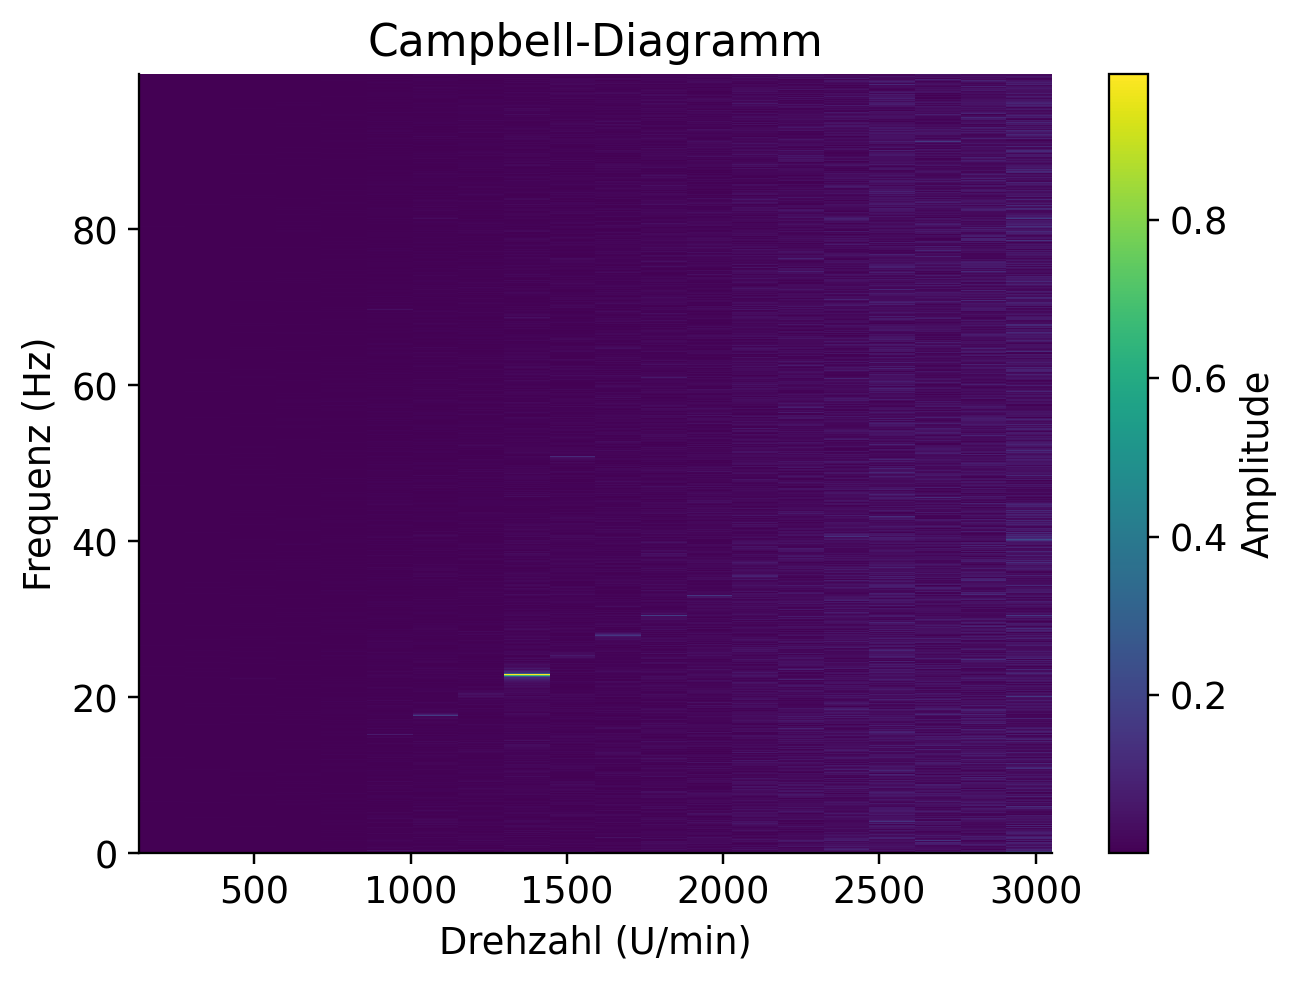

In [32]:
# Visualisierung der Daten als Bild mit imshow aus der Matplotlib-Bibliothek
plt.imshow(np.transpose(amp), extent=(min(rpm_values), max(rpm_values), min(frequenz_min_list), max(frequenz_max_list)), aspect='auto', cmap='viridis', interpolation="none", origin="lower")
# Titel für das Diagramm setzen
plt.title('Campbell-Diagramm')
# Beschriftung der x-Achse
plt.xlabel('Drehzahl (U/min)')
# Beschriftung der y-Achse
plt.ylabel('Frequenz (Hz)')
# Farbskala (Colorbar) für die Amplituden hinzufügen
plt.colorbar(label = 'Amplitude')
# Diagramm anzeigen
plt.show()

## Zweiter Datensatz: Prüfstand 2

#### 1. Einlesen der Mess- und Metadaten

In [33]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)


measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)


{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [34]:
importlib.reload(m_postprocessing)  
# Pfad zur Messdatenordner und Dateiname erstellen
datapath = path_measurement_folder + '/' + filename  
# Dictionaries für Motor-Drehzahl, skaliertes Amplituden-Spektrum und Frequenzwerte initialisieren
motor = {}
scaled_ampl  = {}
frequency  = {}
# H5-Datei öffnen und Daten verarbeiten
with h5py.File(datapath, 'r') as file:
    for ii in range(len(file.keys())):
        # Beschleunigungsdaten aus der H5-Datei extrahieren
        x_array = np.array( file[str(ii)]["RawData"][uuid_acceleration]["acceleration_x"])                                                           
        y_array = np.array( file[str(ii)]["RawData"][uuid_acceleration]["acceleration_y"])                                                         
        z_array = np.array( file[str(ii)]["RawData"][uuid_acceleration]["acceleration_z"])                                                            
        time_array = np.array( file[str(ii)]["RawData"][uuid_acceleration]["timestamp"])   
        list_drehzahl = np.array( file[str(ii)]["RawData"][uuid_motor_rpm]["motor_rpm"]) 
        # Motor-Drehzahlen in Dictionary speichern
        motor[str(ii)] = list_drehzahl
        # Vektorielle Beschleunigung berechnen
        acc_absolut = m_postprocessing.get_vec_accel(x_array, y_array, z_array)
        # Interpolation der Beschleunigungsdaten
        interpolation_acc = m_postprocessing.interpolation(time_array,  acc_absolut, interpolation_points)
        # Berechnung des skalierten Amplituden-Spektrums und der Frequenzwerte
        scaled_amplitude_spectrum, frequency_values = m_postprocessing.my_fft_scaled(interpolation_acc, interpolation_points)
        # Ergebnisse in entsprechende Dictionaries speichern
        scaled_ampl[str(ii)] = scaled_amplitude_spectrum
        frequency[str(ii)] = frequency_values
# Listen für spätere Verwendung erstellen
amp = [amp_list for amp_list in scaled_ampl.values()]
rpm_values = [rpm_value for rpm_value in motor.values()]
# Minimale und maximale Frequenzwerte aus den Daten extrahieren
frequenz_min_list = [min_list[0] for min_list in frequency.values()]
frequenz_max_list = [max_list[-1] for max_list in frequency.values()]
 
 







#### 3. Darstellung mittels Campbell-Diagramm

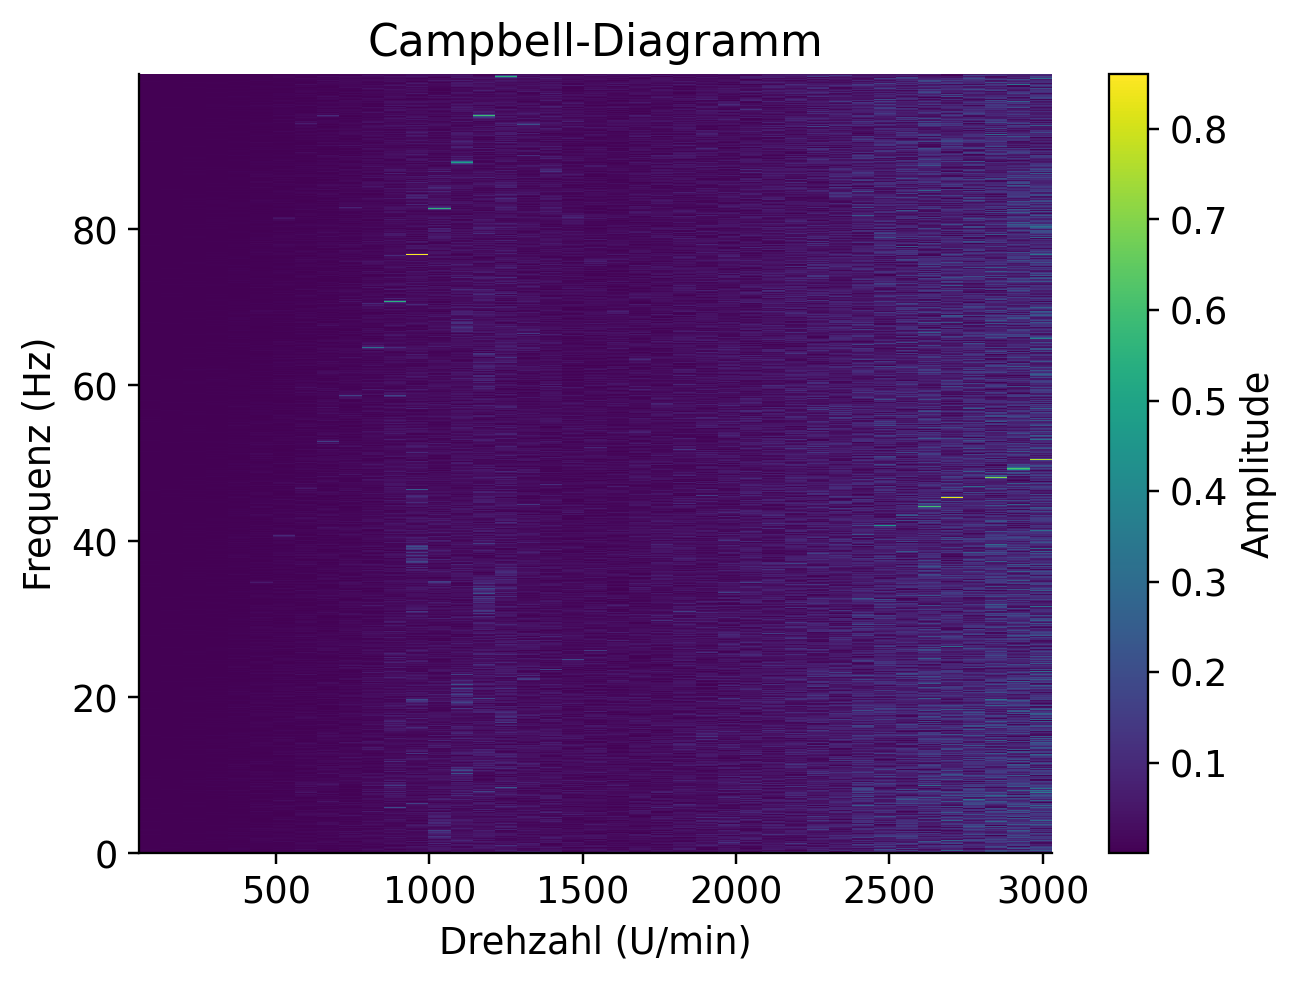

In [26]:
# Visualisierung der Daten als Bild mit imshow aus der Matplotlib-Bibliothek
plt.imshow(np.transpose(amp), extent=(min(rpm_values), max(rpm_values), min(frequenz_min_list), max(frequenz_max_list)), aspect='auto', cmap='viridis', interpolation="none", origin="lower")
# Titel für das Diagramm setzen
plt.title('Campbell-Diagramm')
# Beschriftung der x-Achse
plt.xlabel('Drehzahl (U/min)')
# Beschriftung der y-Achse
plt.ylabel('Frequenz (Hz)')
# Farbskala (Colorbar) für die Amplituden hinzufügen
plt.colorbar(label = 'Amplitude')
# Diagramm anzeigen
plt.show()

## Dritter Datensatz: Prüfstand 4

#### 1. Einlesen der Mess- und Metadaten

In [36]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240109_104244_lavalrotor_01_04"
)  # path to the folder with H5-file and metadata
filename = "data_20240109_104244_lavalrotor_01_04.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)


measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)



{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3d20-6332-83f5-6876b760dcf3": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [37]:
importlib.reload(m_postprocessing)  
# Pfad zur Messdatenordner und Dateiname erstellen
datapath = path_measurement_folder + '/' + filename  
# Dictionaries für Motor-Drehzahl, skaliertes Amplituden-Spektrum und Frequenzwerte initialisieren
motor = {}
scaled_ampl  = {}
frequency  = {}
# H5-Datei öffnen und Daten verarbeiten
with h5py.File(datapath, 'r') as file:
    for ii in range(len(file.keys())):
        # Beschleunigungsdaten aus der H5-Datei extrahieren
        x_array = np.array( file[str(ii)]["RawData"][uuid_acceleration]["acceleration_x"])                                                           
        y_array = np.array( file[str(ii)]["RawData"][uuid_acceleration]["acceleration_y"])                                                         
        z_array = np.array( file[str(ii)]["RawData"][uuid_acceleration]["acceleration_z"])                                                            
        time_array = np.array( file[str(ii)]["RawData"][uuid_acceleration]["timestamp"])   
        list_drehzahl = np.array( file[str(ii)]["RawData"][uuid_motor_rpm]["motor_rpm"]) 
        # Motor-Drehzahlen in Dictionary speichern
        motor[str(ii)] = list_drehzahl
        # Vektorielle Beschleunigung berechnen
        acc_absolut = m_postprocessing.get_vec_accel(x_array, y_array, z_array)
        # Interpolation der Beschleunigungsdaten
        interpolation_acc = m_postprocessing.interpolation(time_array,  acc_absolut, interpolation_points)
        # Berechnung des skalierten Amplituden-Spektrums und der Frequenzwerte
        scaled_amplitude_spectrum, frequency_values = m_postprocessing.my_fft_scaled(interpolation_acc, interpolation_points)
        # Ergebnisse in entsprechende Dictionaries speichern
        scaled_ampl[str(ii)] = scaled_amplitude_spectrum
        frequency[str(ii)] = frequency_values
# Listen für spätere Verwendung erstellen
amp = [amp_list for amp_list in scaled_ampl.values()]
rpm_values = [rpm_value for rpm_value in motor.values()]
# Minimale und maximale Frequenzwerte aus den Daten extrahieren
frequenz_min_list = [min_list[0] for min_list in frequency.values()]
frequenz_max_list = [max_list[-1] for max_list in frequency.values()]
 
 



#### 3. Darstellung mittels Campbell-Diagramm

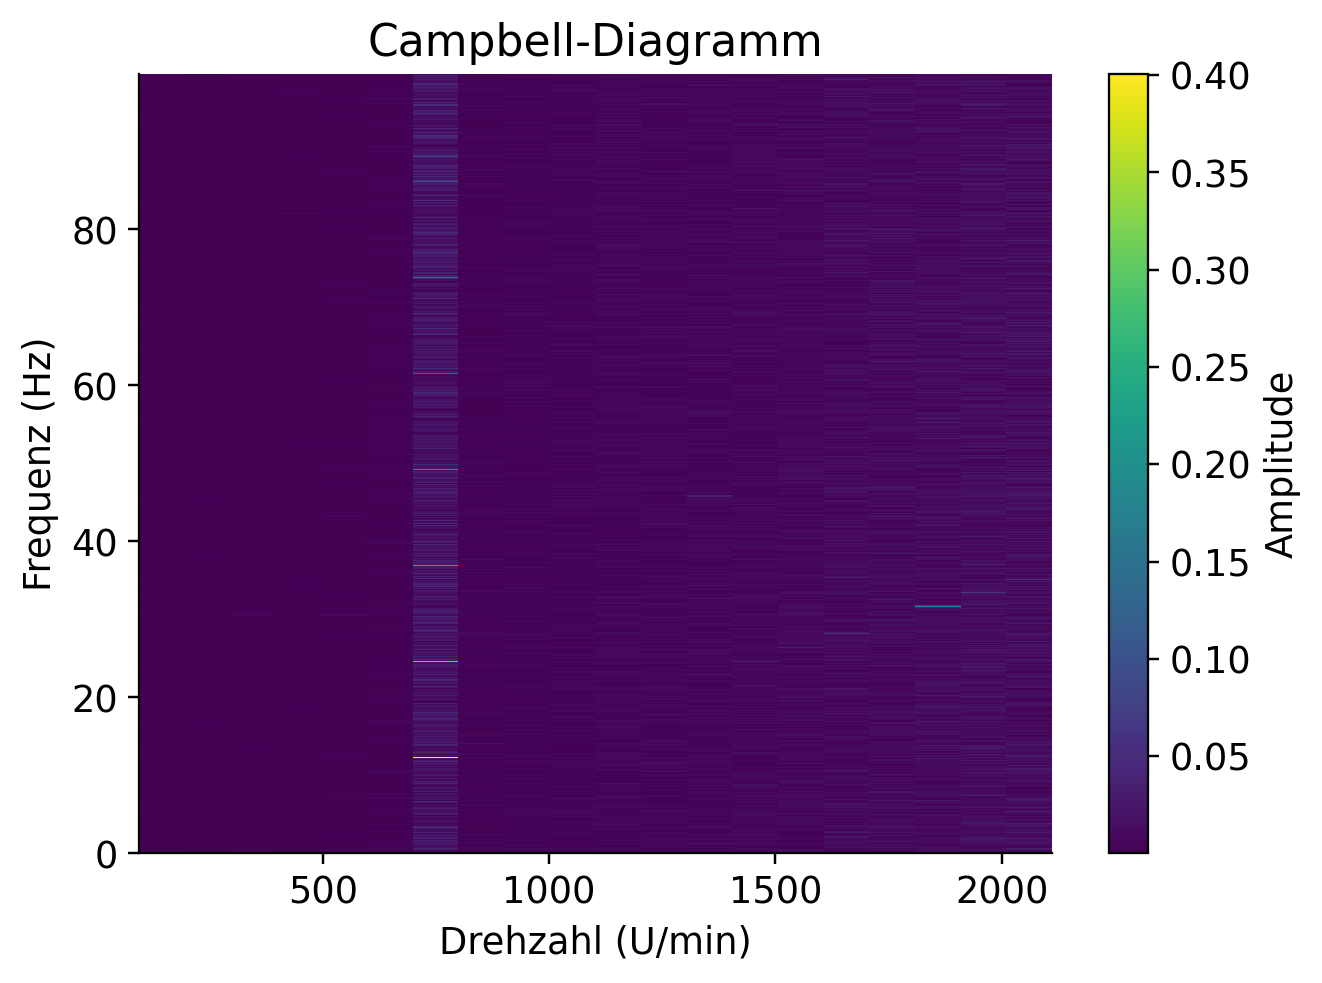

In [38]:
# Visualisierung der Daten als Bild mit imshow aus der Matplotlib-Bibliothek
plt.imshow(np.transpose(amp), extent=(min(rpm_values), max(rpm_values), min(frequenz_min_list), max(frequenz_max_list)), aspect='auto', cmap='viridis', interpolation="none", origin="lower")
# Titel für das Diagramm setzen
plt.title('Campbell-Diagramm')
# Beschriftung der x-Achse
plt.xlabel('Drehzahl (U/min)')
# Beschriftung der y-Achse
plt.ylabel('Frequenz (Hz)')
# Farbskala (Colorbar) für die Amplituden hinzufügen
plt.colorbar(label = 'Amplitude')
# Diagramm anzeigen
plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Da mein Code mit dem Datensatz aus dem Versuch nicht geklappt hat, musste ich auf die Ersatzdaten zurückgreifen. Im Allgemeinen kann man sagen, dass die rechnerisch ermittelte Eigenfrequenz recht nah an der experimantell ermitteltten Eigenfrequenz dran ist. 

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Die Laborversuche haben Spaß gemacht und die Mechanik dahinter ist interessant, aber die digitale Auswertung hat mir überhaupt keinen Spaß gemacht. Dies hat mir jedoch gezeigt, in welche Richtung ich später als Maschinenbauer auf keinen Fall gehen will. Sollte ich dies nicht umgehen können in diesem Berufszweig, werde ich alternativ dazu einen Surfboardverleih in Costa Rica eröffnen. 